In [7]:
import ast
#import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
from PIL import Image
#import progressbar
import pydicom as dicom
#import pylibjpeg
import torch
import torch.optim as optim
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from typing import List, Tuple, Dict, Optional, Any
import pickle


In [2]:
MODEL_PATH = "/media/luisa/Volume/AML/models/fasterrcnn_resnet50_fpn_10_epochs_diffNoBox_v01/model/fasterrcnn_resnet50_fpn_10_epochs_diffNoBox_v0.pth"
TRAINSET_INDICES_PATH = "/media/luisa/Volume/AML/models/fasterrcnn_resnet50_fpn_10_epochs_diffNoBox_v01/test_set_fasterrcnn_resnet50_fpn_10_epochs_diffNoBox_v0.csv"

ROOT =  '/media/luisa/Volume/AML/siim-covid19-detection'
CLEAN_TRAIN_PATH = '/media/luisa/Volume/AML/train_image_level_clean_paths.csv'
#CLEAN_TRAIN_PATH = '/media/luisa/Volume/AML/train_image_level_clean_paths_NOTNA.csv'

CLASSES = ['Negative for Pneumonia',' Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

#parameters for evaluation
MIN_IOU = 0.5
NMS_THRESHOLD = 0.3

device = torch.device("cuda")

model  = torchvision.models.detection.fasterrcnn_resnet50_fpn(max_size =240 )



In [3]:
#### list of all image_ids that are used in test set (ids can be anything that unique identifies an image of the test set to map gt and predictions) ####
indices_df = pd.read_csv(TRAINSET_INDICES_PATH)

# remove these lines if df colum naming is fixed during training
indices_df = indices_df.drop(['Unnamed: 0'], axis = 1)
indices_df = indices_df.rename(columns={"0": 'image_id'}, errors="raise")
print(indices_df.columns)
indices_df.head()

Index(['image_id'], dtype='object')


,image_id
0,4287
1,3093
2,648
3,988
4,3050


In [4]:
# load from model state dict

'''
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

'''
# load entire model 

model = torch.load(MODEL_PATH)
#model.to(device)
model.eval()
print()





In [7]:
# Helper functions for torchvision faster rcnn adapted from official repo

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    #no data augmentation for now, maybe implement later
    #if train:
        #transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

class ToTensor(torch.nn.Module):
    def forward(self, image: torch.Tensor,
                target: Optional[Dict[str, torch.Tensor]] = None) -> Tuple[torch.Tensor, Optional[Dict[str, torch.Tensor]]]:
        image = to_tensor(image)
        return image, target
    
def to_tensor(pic):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    This function does not support torchscript.

    See :class:`~torchvision.transforms.ToTensor` for more details.

    Args:
        pic (PIL Image or numpy.ndarray): Image to be converted to tensor.

    Returns:
        Tensor: Converted image.
    """
    #if not(_is_pil_image(pic) or _is_numpy(pic)):
        #raise TypeError('pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

    #if not(_is_numpy(pic)):
        #raise TypeError('pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

    #if _is_numpy(pic) and not _is_numpy_image(pic):
        #raise ValueError('pic should be 2/3 dimensional. Got {} dimensions.'.format(pic.ndim))

    default_float_dtype = torch.get_default_dtype()

    if isinstance(pic, np.ndarray):
        # handle numpy array
        if pic.ndim == 2:
            pic = pic[:, :, None]

        img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
        # backward compatibility
        if isinstance(img, torch.ByteTensor):
            return img.to(dtype=default_float_dtype).div(255)
        else:
            return img

    if accimage is not None and isinstance(pic, accimage.Image):
        nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
        pic.copyto(nppic)
        return torch.from_numpy(nppic).to(dtype=default_float_dtype)

    # handle PIL Image
    mode_to_nptype = {'I': np.int32, 'I;16': np.int16, 'F': np.float32}
    img = torch.from_numpy(
        np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True)
    )

    if pic.mode == '1':
        img = 255 * img
    img = img.view(pic.size[1], pic.size[0], len(pic.getbands()))
    # put it from HWC to CHW format
    img = img.permute((2, 0, 1)).contiguous()
    if isinstance(img, torch.ByteTensor):
        return img.to(dtype=default_float_dtype).div(255)
    else:
        return img

In [8]:
# dataset that contains only image_ids of test set

class Test_only_ImageLevelSiimCovid19Dataset(torch.utils.data.Dataset):
    def __init__(self, root = ROOT, transforms = get_transform(train=True)):
        self.root = root
        self.transforms = transforms
        
        #use only indices that are part of previous test set
        test_indices = indices_df['image_id']
        test_set  = pd.read_csv(CLEAN_TRAIN_PATH)
        
        test_set = test_set[test_set.index.isin(test_indices)]

        # .csv under CLEAN_TRAIN_PATH contains all image paths with their bounding box annotations
        #self.imgs = pd.read_csv(CLEAN_TRAIN_PATH)['path'].tolist()
        self.imgs = test_set['path'].tolist()
        #self.annotations = pd.read_csv(CLEAN_TRAIN_PATH)['boxes'].tolist()
        self.annotations = test_set['boxes'].tolist()
        
        self.study_class_labels = test_set['study_label'].tolist()
        
    def __getitem__(self, idx):
        # load images and annotations
    
        img_path = self.imgs[idx]
        img = np.float32(dicom.dcmread(img_path).pixel_array)
        
        study_class_label = self.study_class_labels[idx]
        
        if self.annotations[idx] is np.NaN:
            boxes_dict = []
            
        else:
            boxes_dict = ast.literal_eval(self.annotations[idx])
            
        num_obj = len(boxes_dict)
    
        boxes = []
        for i in boxes_dict:

            x_min = i['x']
            y_min = i['y']
            x_max = i['x'] + i['width']
            y_max = i['y'] + i['height']
            boxes.append([x_min, y_min, x_max, y_max])
            
            


                
        #only one class label at this step: opacity
        labels = torch.ones((num_obj,), dtype=torch.int64)
        iscrowd = torch.zeros((num_obj,), dtype=torch.int64) # assuming there are no crowds
        
      
        #handle images without boxes in annotation
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            
        
        '''
        if len(boxes) == 0:
            boxes = [[0, 0, 1, 1]]
            labels = torch.zeros(1, dtype=torch.int64)  # label for background is 0
            #iscrowd = torch.zeros((1,), dtype=torch.int64) # assuming there are no crowds
            #boxes = []
            #labels = torch.zeros(0, dtype=torch.int64)  # label for background is 0
        '''    
      
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        study_label = 0
        if study_class_label == 'Typical Appearance':
            study_label = 1
        if study_class_label == 'Indeterminate Appearance':
            study_label = 2
        if study_class_label == 'Atypical Appearance':
            study_label = 3

        study_label = torch.tensor([study_label])
        
        
        image_id = torch.tensor([idx])
        
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        
        target["area"] = area
        
        target["study_label"] = study_label
        '''
        target['iscrowd'] = iscrowd
        
        '''
        
        
        # TODO: transforms for test set
        #transform_img = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
        #img = transform_img(img)
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)        
        

        return img, target
        
        
    def __len__(self):
        return len(self.imgs)

In [9]:
# custom colate_fn 
def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
# dataloader for test set
dataset_test = Test_only_ImageLevelSiimCovid19Dataset(ROOT, get_transform(train=False))

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [12]:
%%time

#### create inputs for evaluation ####

# 1.) all_preds_df: DataFrame with all predicted boxes ('pred_boxes'), their confidence scores ('pred_scores') and their 'image_id' (unique identifier of image in which box was predicted)
#     all_pred_boxes_df HAS TO BE sorted in ascending order of pred_scores!

# 2.) all_gt_boxes: array of [image_id, gt_box, used_flag], for each gt box. all used_flags are initialy set to False


bar =progressbar.ProgressBar()




all_preds = [] #all predicted boxes with image_id and score
#gt_dict = dict() #key: image_id, value: array with gt boxes

all_gt_boxes = [] # all gt boxes  [image_id, box, used]

for batch in bar(data_loader_test):
    
    images, targets = batch

    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    

    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)

    cpu_device = torch.device("cpu")

    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    #print("1")
   
    
    box_candidates = outputs[0]['boxes']
    scores_candidates = outputs[0]['scores']
    
   
    # apply non-maximum suppression  
    keep = torchvision.ops.nms(box_candidates, scores_candidates, NMS_THRESHOLD)
    
    
    pred_boxes = []
    pred_scores = []
    for b in keep :
        pred_b = box_candidates[b].cpu().detach().numpy()
        #print("2")
        pred_s = scores_candidates[b].cpu().detach().numpy()
        pred_boxes.append(pred_b)
        pred_scores.append(pred_s)
  
    #pred_boxes = outputs[0]['boxes'].detach().numpy()
    #pred_scores = outputs[0]['scores'].detach().numpy()
    
    image_id = targets[0]['image_id'].cpu().numpy()
    image_id = image_id[0]
    gt_boxes = targets[0]['boxes'].cpu().numpy()
    
    #gt_dict[image_id] = gt_boxes
    gt_box = []
    for b in range(len(gt_boxes)):
        gt_boxes_id = [image_id, gt_boxes[b], False]
        #gt_box.append(gt_boxes_id)
        all_gt_boxes.append(gt_boxes_id)   
    #all_gt_boxes.append(gt_box)    
        
    for b in range(len(pred_boxes)):
        boxes_scores_id = [image_id, pred_boxes[b], pred_scores[b]]
        all_preds.append(boxes_scores_id)
        

all_preds_df = pd.DataFrame(all_preds, columns=['image_id', 'pred_boxes', 'pred_scores'])    
all_preds_df = all_preds_df.sort_values('pred_scores',  ascending=False)

#all_gt_boxes_df = pd.DataFrame(all_gt_boxes, columns=['image_id', 'gt_boxes', 'used']) 

# inices = all_gt_boxes[0]
# inices = all_gt_boxes[1]
# inices = all_gt_boxes[2]
all_gt_boxes_ = np.array(all_gt_boxes).transpose()

CPU times: user 43.9 s, sys: 8.79 s, total: 52.7 s
Wall time: 3min 42s



<timed exec>:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [13]:
print(len(all_preds_df))
print(len(all_preds_df[all_preds_df['pred_scores'] > 0.5]))

# confidence threshold of .5
all_preds_df_50conf = all_preds_df[all_preds_df['pred_scores'] > 0.5]


14537
5862


In [14]:
all_preds_df.head()

,image_id,pred_boxes,pred_scores
9035,1238,"[0.0, 0.0, 3408.0, 2800.0]",1.0
14192,1139,"[0.0, 1610.4758, 1878.0297, 1923.6415]",1.0
8946,300,"[1318.6195, 0.0, 1325.9933, 1760.0001]",1.0
8945,300,"[1422.3435, 0.0, 1423.026, 1760.0001]",1.0
1888,625,"[2714.6084, 492.90872, 2832.0, 1701.7156]",1.0


In [16]:
print(len(all_gt_boxes))
print(len(all_preds_df))

1580
14537


In [10]:
#####################################
#
#     LOAD FROM FILES
#
#####################################
with open("all_preds.dat", "rb") as file:
    all_preds = pickle.load(file)
with open("all_gt_boxes.dat", "rb") as file:
    all_gt_boxes = pickle.load(file)
all_preds_df = pd.DataFrame(all_preds, columns=['image_id', 'pred_boxes', 'pred_scores'])    
all_preds_df = all_preds_df.sort_values('pred_scores',  ascending=False)

In [11]:
all_preds_df.head()


,image_id,pred_boxes,pred_scores
17,4356,"[0.18052556, 0.21400025, 0.47705406, 0.7356516]",0.690063
1,3697,"[0.07475066, 0.21586698, 0.38240293, 0.6904757]",0.681783
18,4356,"[0.62135273, 0.27515095, 0.8811942, 0.7460577]",0.667623
10,1620,"[0.60053945, 0.17989299, 0.87656426, 0.7830161]",0.652406
0,5084,"[0.66927755, 0.28014064, 0.8739166, 0.70936036]",0.630857


In [17]:
#all_gt_boxes = np.array(all_gt_boxes).transpose()[0]

all_gt_boxes = all_gt_boxes_[:]

MIN_IOU = 0.5

#arrays for TP and FP         
nd = len(all_preds_df)
tp = [0] * nd # creates an array of zeros of size nd
fp = [0] * nd
all_tp = 0
all_fp = 0

#for each detected objct (detected_box)
for i in range (len(all_preds_df)):
    img_id = all_preds_df.iloc[i]['image_id']
    pred_box = all_preds_df.iloc[i]['pred_boxes']

    #count true positives:
    # set temp_max_iou = -1
    # set temp_gt_match = -1

    iou_max = -1
    gt_match = -1
    gt_row = -1        
    
    #compare the detected_box with all gt_boxes for this image to find max IOU
        #for box in gt boxes of image:
                   
                                           
    '''
    for idx, row in gt_boxes_i.iterrows():
        bb_gt = row['gt_boxes']
        #print(bb_gt)
        bb_pred = pred['pred_boxes']
        used = row['used']

        #print(bb_pred)
        #print()
        #print(used)    
    '''
    #gt_boxes_i = all_gt_boxes[1][np.where(all_gt_boxes[0] == img_id)]
    #used_flag_i = all_gt_boxes[2][np.where(all_gt_boxes[0] == img_id)]
    
    for j in range (len(all_gt_boxes[0])):
        if all_gt_boxes[0][j] == img_id:
            
            bb_gt = all_gt_boxes[1][j]
            used = all_gt_boxes[2][j]
            
            bb_pred = pred_box      
            
            if used == False:
                # calculate IOU

                intersect_box = [max(bb_pred[0],bb_gt[0]), max(bb_pred[1],bb_gt[1]), min(bb_pred[2],bb_gt[2]), min(bb_pred[3],bb_gt[3])]
                #print(intersect_box)
                intersect_w = intersect_box[2] - intersect_box[0] + 1
                intersect_h = intersect_box[3] - intersect_box[1] + 1
                if intersect_w > 0 and intersect_h >0:


                    union_area = (bb_pred[2] - bb_pred[0] + 1) * (bb_pred[3] - bb_pred[1] + 1) + (bb_gt[2] - bb_gt[0] + 1) * (bb_gt[3] - bb_gt[1] + 1) - intersect_w * intersect_h

                    iou_i = intersect_w * intersect_h / union_area
                    #print(iou_i)

                    # find max iou for this prediction
                    if iou_i > iou_max:
                        iou_max = iou_i
                        gt_match = pred_box  
                        iou_max_gt_box_idx = j
                        #print(iou_max)


    if iou_max >= MIN_IOU:
        #print('yes!')
        #set flag used to 'True'
        all_gt_boxes[2][iou_max_gt_box_idx] = True
        #used_flag_i = all_gt_boxes[2][np.where(all_gt_boxes[0] == img_id)]
        #all_gt_boxes_df.at[gt_row.name, 'used'] = True
        
        tp[i] = 1
        all_tp +=1
    else:
        fp[i] =1
        all_fp +=1    
    
    # fp and tp arrays are sorted in same order as dataframe with predictions  

    #calculate precision/recall
    #cumsum = 0
    

#add cols with cumsum of tp and fp cols
#add column rec: rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
#add column prec: prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])

#ap, mrec, mprec = voc_ap(rec[:], prec[:])
#siehe unten weiter

print(all_tp)
print(all_fp)

143
14394


In [19]:
def voc_ap(rec_, prec_):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    #rec.insert(0, 0.0) # insert 0.0 at begining of list
    #rec.append(1.0) # insert 1.0 at end of list
    mrec = np.concatenate([[0.0],rec_,[1.0]])
    
    
    
    #prec.insert(0, 0.0) # insert 0.0 at begining of list
    #prec.append(0.0) # insert 0.0 at end of list
    mpre = np.concatenate([[0.0],prec_ ,[0.0]])
    #print(prec_)
    
    
    
    
    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
        

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec

    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
   
    
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    #for i in range(len(mpre)-2, -1, -1):
        #mpre[i] = max(mpre[i], mpre[i+1])
    #for i in range(mpre.size - 1, 0, -1):
     #   mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    
    
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
    '''
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    '''

    
    return ap, mrec, mpre

In [21]:
#tp = tp[:5862]
#fp = fp[:5862]


sum_AP = 0

#rec = tp[:]
#for i in range (len(tp)):
    #rec[i] = float(tp[i]) / len(all_preds_df)
    
tp_cumsum = np.cumsum(tp, dtype=float)
rec = tp_cumsum / len(tp)

    
#prec = tp[:]
#for i in range (len(tp)):
    #prec[i] = float(tp[i]) / (fp[i] + tp[i])
fp_cumsum = np.cumsum(fp, dtype=float)
prec = tp_cumsum /(fp_cumsum + tp_cumsum)


    
class_name = 'opacity'
ap, mrec, mprec = voc_ap(rec[:], prec[:])

#print(mprec)

sum_AP += ap
text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)


print(text)
    
"""
rec = tp[:]
for idx, val in enumerate(tp):
    rec[idx] = float(tp[idx]) / len(all_preds_df)
#print(rec)
prec = tp[:]
for idx, val in enumerate(tp):
    prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])
#print(prec)

ap, mrec, mprec = voc_ap(rec[:], prec[:])
sum_AP += ap
text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)

#Write to output.txt
"""

#add cols with cumsum of tp and fp cols
#add column rec: rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
#add column prec: prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])

#ap, mrec, mprec = voc_ap(rec[:], prec[:])
#siehe unten weiter


0.01% = opacity AP 


'\nrec = tp[:]\nfor idx, val in enumerate(tp):\n    rec[idx] = float(tp[idx]) / len(all_preds_df)\n#print(rec)\nprec = tp[:]\nfor idx, val in enumerate(tp):\n    prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])\n#print(prec)\n\nap, mrec, mprec = voc_ap(rec[:], prec[:])\nsum_AP += ap\ntext = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)\n\n#Write to output.txt\n'

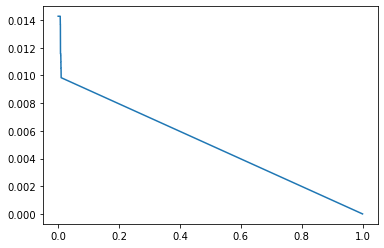

In [22]:
plt.plot(mrec, mprec)